Equalization term '{woman}' not found in embeddings dictionary!


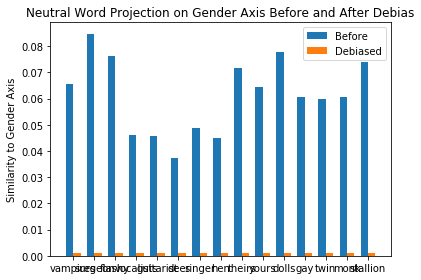

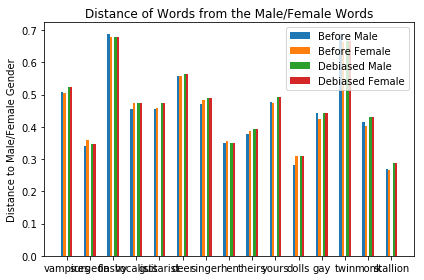

In [2]:
import numpy as np
import pair_io
from ReadEmbeddings import ReadEmbeddingsFile
from Tests import PlotEmbeddingDistances, PlotGenderSimilarity

def center_matrix(matrix):
    col_avgs = np.average(matrix, axis=0)
    centered = matrix - col_avgs
    assert np.max(np.average(centered, axis=0) - np.zeros(matrix.shape[1])) < 1e-10

    return matrix - col_avgs


def get_principal_axes(matrix, num_axes=10):
    centered = center_matrix(matrix)
    u, s, v_t = np.linalg.svd(centered)

    return v_t[:num_axes]


def get_bias_subspace(definitional_pairs, num_axes=10):
    embedding_dimension = list(definitional_pairs.items())[0][1][0].shape[0]
    subspace_basis = np.zeros(
        (len(definitional_pairs) * 2, embedding_dimension)
    )

    # for i, (u, v) in enumerate(definitional_pairs):
    #     mean = (u + v) / 2
    #     basis_u = u - meanx
    #     basis_u /= np.linalg.norm(basis_u)
    #     assert np.linalg.norm(basis_u) - 1 < 1e-10
    #     basis_v = v - mean
    #     basis_v /= np.linalg.norm(basis_v)
    #     assert np.linalg.norm(basis_v) - 1 < 1e-10
    #
    #     subspace_basis[i*2] = basis_u
    #     subspace_basis[(i*2)+1] = basis_v

    for i, ((_, _), (woman_embedding, man_embedding)) in enumerate(definitional_pairs.items()):
        mean = (woman_embedding + man_embedding) / 2
        woman_basis = woman_embedding - mean
        woman_basis /= np.linalg.norm(woman_basis)
        assert np.linalg.norm(woman_basis) - 1 < 1e-10
        man_basis = man_embedding - mean
        man_basis /= np.linalg.norm(man_basis)
        assert np.linalg.norm(man_basis) - 1 < 1e-10

        subspace_basis[i*2] = woman_basis
        subspace_basis[(i*2)+1] = man_basis

    return get_principal_axes(subspace_basis, num_axes)


def get_projection(vector, basis_vectors):
    new_vector = np.zeros_like(vector)
    for basis_vector in basis_vectors:
        new_vector += (vector @ basis_vector) * basis_vector

    return new_vector


def orthogonalize(vector, basis_vectors):
    return vector - get_projection(vector, basis_vectors)


def neutralize(embeddings, bias_subspace):
    # re_embedded = np.zeros_like(embeddings)
    # for i, embedding in enumerate(embeddings):
    #     # orthogonal_embedding = embedding - get_projection(embedding, bias_subspace)
    #     # orthogonal_embedding /= np.linalg.norm(orthogonal_embedding)
    #     # assert np.linalg.norm(orthogonal_embedding) == 1
    #     # re_embedded[i] = orthogonal_embedding
    #
    #     re_embedded[i] = orthogonalize(embedding, bias_subspace)

    re_embedded = {}
    for text, embedding in embeddings.items():
        re_embedded[text] = orthogonalize(embedding, bias_subspace)
        re_embedded[text] /= np.linalg.norm(re_embedded[text])
        assert np.linalg.norm(re_embedded[text]) - 1 < 1e-10

    return re_embedded


def equalize(equalize_pairs, bias_subspace):
    # equalized_pairs = np.zeros_like(equalize_pairs)
    # for i, (u, v) in enumerate(equalize_pairs):
    #     mean = orthogonalize(
    #         (u + v) / 2,
    #         bias_subspace
    #     )
    #     coefficient = np.sqrt(
    #         1 - np.square(
    #             np.linalg.norm(mean)
    #         )
    #     )
    #     equalized_u = mean + coefficient * bias_subspace
    #     equalized_u /= np.linalg.norm(equalized_u)
    #     assert np.linalg.norm(equalized_u) == 1
    #     equalized_v = mean - coefficient * bias_subspace
    #     equalized_v /= np.linalg.norm(equalized_v)
    #     assert np.linalg.norm(equalized_v) == 1
    #
    #     equalized_pairs[i*2] = equalized_u
    #     equalized_pairs[(i*2)+1] = equalized_v

    equalized_pairs = {}
    for (woman_text, man_text), (woman_embedding, man_embedding) in equalize_pairs.items():
        mean = orthogonalize(
            (woman_embedding + man_embedding) / 2,
            bias_subspace
        )
        coefficient = np.sqrt(
            1 - np.square(
                np.linalg.norm(mean)
            )
        )
        equalized_woman = mean + coefficient * bias_subspace
        equalized_woman /= np.linalg.norm(equalized_woman)
        assert np.linalg.norm(equalized_woman) - 1 < 1e-10
        equalized_man = mean - coefficient * bias_subspace
        equalized_man /= np.linalg.norm(equalized_man)
        assert np.linalg.norm(equalized_man) - 1 < 1e-10

        equalized_pairs[woman_text] = equalized_woman
        equalized_pairs[man_text] = equalized_man

    return equalized_pairs


def produce_debiased_embeddings(embedding_dict, num_principal_axes=10):
    # produce definitional pairs for principal component analysis
    definitional_pairs_raw = pair_io.get_definitional_pairs()
    definitional_pairs_dict = {}    # key: (woman, man); value: (woman_embedding, man_embedding)
    for woman, man in definitional_pairs_raw:
        if woman in embedding_dict and man in embedding_dict:
            # definitional_pairs.append(
            #     (embedding_dict[woman], embedding_dict[man])
            # )
            definitional_pairs_dict[(woman, man)] = (
                embedding_dict[woman], embedding_dict[man]
            )
        else:
            if woman not in embedding_dict:
                print("Definitional term '{woman}' not found in embeddings dictionary!")
            if man not in embedding_dict:
                print("Definitional term '{man}' not found in embeddings dictionary!")

    # separate definitional embeddings from non-definitional embeddings,
    # because the definitional embeddings will not be re-embedded
    definitional_single_words = set(
        np.array(definitional_pairs_raw).flatten().tolist()
    )
    non_definitional_embeddings_dict = {
        text: embedding for text, embedding in embedding_dict.items() if text not in definitional_single_words
    }

    # define bias subspace with definitional pairs, and neutralize all non-definitional embeddings
    bias_subspace = get_bias_subspace(definitional_pairs_dict, num_principal_axes)
    neutralized = neutralize(non_definitional_embeddings_dict, bias_subspace)

    # produce equalization pairs
    equalization_pairs_raw = pair_io.get_equalization_pairs()
    equalization_pairs_dict = {}  # key: (woman, man); value: (woman_embedding, man_embedding)
    for woman, man in pair_io.get_equalization_pairs():
        if woman in embedding_dict and man in embedding_dict:
            # equalize_pairs.append(
            #     (embedding_dict[woman], embedding_dict[man])
            # )
            equalization_pairs_dict[(woman, man)] = (
                embedding_dict[woman], embedding_dict[man]
            )
        else:
            if woman not in embedding_dict:
                print("Equalization term '{woman}' not found in embeddings dictionary!")
            if man not in embedding_dict:
                print("Equalization term '{man}' not found in embeddings dictionary!")
    equalized = equalize(equalization_pairs_dict, bias_subspace)

    return bias_subspace, neutralized, equalized


if __name__ == '__main__':
    embedding_dict = ReadEmbeddingsFile()

    # normalize all embeddings, then debias (re-embed) them
    for text, embedding in embedding_dict.items():
        embedding_dict[text] = embedding / np.linalg.norm(embedding)
        assert np.linalg.norm(embedding_dict[text]) - 1 < 1e-10
    subspace, neutralized, equalized = produce_debiased_embeddings(embedding_dict)
    pairs = pair_io.get_definitional_pairs()
    pair_embeds = []
    pair_debias = []
    for (u,v) in pairs:
        pair_embeds.append([embedding_dict[u],embedding_dict[v]])
        #pair_debias.append([equalized[u],equalized[v]])
    Neutrals = ["vampires","surgeon","flashy","vocalists","guitarist","deer","singer","hen","theirs","yours","dolls","gay","twin","monk","stallion"]
    PlotEmbeddingDistances(Neutrals,pair_embeds,pair_embeds,embedding_dict,neutralized)
    PlotGenderSimilarity(Neutrals,pair_embeds,pair_embeds,embedding_dict,neutralized)
